# **Automate Pnemonia Detection using Chest X-Rays**
Author: Rajpal Virk | 20 April 2020

## **Introduction**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Pneumonia, an infectious lung disease, is a major cause of morbidity and mortality that affects approximately four million persons in North America each year (Auble TE, 1998). About one third to one half of pneumonia cases are caused by bacteria. Despite technologic advances in medicine, the diagnosis and treatment of pneumonia remain challenging for clinicians. Empiric antibiotic treatment is usually initiated before a definitive microbiologic diagnosis is available. Viruses, bacteria, and fungi can all cause pneumonia. In the United States, common causes of viral pneumonia are influenza and respiratory syncytial virus (RSV). A common cause of bacterial pneumonia is Streptococcus pneumoniae (pneumococcus). However, clinicians are not always able to find out which germ caused someone to get sick with pneumonia (Causes of Pneumonia, n.d.). <br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Chest x-rays are currently the best method for diagnosing pneumonia. However, detecting pneumonia in chest x-rays is challenging and requires a radiologist with experience. The process is quite time consuming and sometime this delay results in late access to critical treatment. One of the possible solutions to expedite the X-Ray examination process is by deploying image classification technique of deep learning. The aim of this exercise is to build a neural network to detect the Pneumonia positive patients from x-ray examination.

## **Dataset**
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Dataset is available under label `Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images` on data.mendeley.com [https://data.mendeley.com/datasets/rscbjbr9sj/3]. 

Dataset has following tree structure:
> ChestXRay2017
>>chest_xray
>>>train
>>>>Normal: 1349 Images

>>>>Pneumonia: 3884 Images

>>>test
>>>>Normal: 234 Images

>>>>Pneumonia: 390 Images

![Imbalance train data](image1.png)
*Imbalance train and test data*
![Imbalance test data](image2.png)

Clearly, our data are imbalanced. However, the objective is to build a neural network that can detect Pneumonia with high accuracy, precision and recall, so having more data labelled with class - 'Pneumonia' is better.

## **Methodology**
Following Methodology is adopted here:
![Methodology](image4.png)

## **Data Pre-processing**

In this section, we'll perform following tasks:
1.	Split data (Train and Validation data) : Since we don't have validation data, we'll split our train data into train and validation data. For validation data, we'll move 10% of data out of train data. We'll also separate 1 image for model interpretability purposes. For model interpretability, we'll remove an image labeled Pneumonia. This process will be done manually.
2.	Load data: Let's load data using batch size = 8.
3.	Pre-process data: Data available are in the form of high-resolution images that demand high computation resources and extended period to train the neural network. Moreover, the image resolution is not constant in all images. In order to expedite the process and save on computation resources, data images are resized to 224 pixels by 224 pixels and are normalized using following set parameters. <br>
mean = &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [0.485, 0.456, 0.406] <br>
standard deviation =  &nbsp;&nbsp;[0.229, 0.224, 0.225]
4.	Visualize data: Finally, we'll visualize shuffled data from train data.

In [1]:
# Import required libraries

# Key libraries required
import os
import torch
import torchvision
import numpy, pandas, seaborn
import matplotlib.pyplot as plt
import barbar 
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap


# Set warning to ignore
warnings.filterwarnings('ignore') 

# Get tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Set gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load data

## Root directory to images
data_dir = 'data\ChestXRay2017\chest_xray'
# data_dir = 'data/Sample'
torch.manual_seed(0)

## Transform script
### Set mean and standard deviation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

### Transform function
transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor(), 
            torchvision.transforms.Normalize(mean=mean, std=std)])


## Split, Transform and Load data in batches
batch_size = 64
train_data = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
val_data = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'Val'), transform=transform)
test_data = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'Test'), transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=True) # No batch splitting for testing data


## Print data information
print(f'No. of images in Train data: \t {len(train_data)}.')
print(f'No. of images in Val data: \t {len(val_data)}.')
print(f'No. of images in Test data: \t {len(test_data)}.')
print(f'Binary Labels in Train data: \t {train_data.class_to_idx}.')
print(f'Binary Labels in Val data: \t {val_data.class_to_idx}.')
print(f'Binary Labels in Test data: \t {test_data.class_to_idx}.')
print()
print()

# Visualize data

# define a function to visualize data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(18, 6))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.485, 0.456, 0.406])
    std = numpy.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()


# Visualize training data
## Get a batch of 8 images of training data
train_loader_8 = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
inputs, classes = next(iter(train_loader_8))
class_names = train_data.classes

## Make a grid from batch
out = torchvision.utils.make_grid(inputs)

## Show images
print("Visualize training data: ")
imshow(out, title=[class_names[x] for x in classes])

FileNotFoundError: [Errno 2] No such file or directory: 'data\\ChestXRay2017\\chest_xray/train'

## **Build Network**

Now, to process image classification, we need a convolutional neural network (CNN). <br>
We have 2 options:
1. Build a network from scratch and train it
2. Use pre-trained network and train it.

For this exercise, we'll select option 2. We'll use AlexNet, a pre-trained, convnet and fine tune it.
After downloading pre-trained model, we'll replace the final layer. Original final layer is designed to classify 1000 different classes; however, our data is a 2-class classification problem. So, the final layer must classify output in 2 classes only.

In [3]:
# Building Network

## Using AlexNet network as pre-trained network
model_ft = torchvision.models.alexnet(pretrained=True, progress=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = torch.nn.Linear(num_ftrs,2)
model_ft = model_ft.to(device)

## Loss function and Optimizer
torch.manual_seed(0)
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.000005)

## Print network summary
print('Model Summary: \n', model_ft)
print()

## Print network layout in Tensorboard
inputs, labels = next(iter(train_loader))
writer.add_graph(model_ft, inputs.to(device))

Model Summary: 
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4

## **Train Network**

In this section, we'll train our network using following hyper-parameters.
- No. of epochs = 10
- Learning Rate = 1e-6<br>
Learning Rate is already selected while compiling network.

4709/4709: [===============================>] - ETA 0.8ss
Epoch: 1    Train Loss: 0.1666    Train Correct: 3757    Train Acc: 79%    Val Loss: 0.2087    Val Correct: 482    Val Acc: 92%

4709/4709: [===============================>] - ETA 0.7ss
Epoch: 2    Train Loss: 0.0618    Train Correct: 4464    Train Acc: 94%    Val Loss: 0.0307    Val Correct: 505    Val Acc: 96%

4709/4709: [===============================>] - ETA 1.0ss
Epoch: 3    Train Loss: 0.0128    Train Correct: 4506    Train Acc: 95%    Val Loss: 0.0507    Val Correct: 511    Val Acc: 97%

4709/4709: [===============================>] - ETA 0.9ss
Epoch: 4    Train Loss: 0.0697    Train Correct: 4558    Train Acc: 96%    Val Loss: 0.0838    Val Correct: 511    Val Acc: 97%

4709/4709: [===============================>] - ETA 0.9ss
Epoch: 5    Train Loss: 0.0177    Train Correct: 4573    Train Acc: 97%    Val Loss: 0.0486    Val Correct: 509    Val Acc: 97%

4709/4709: [===============================>] - ETA 0.7ss
Epoch: 

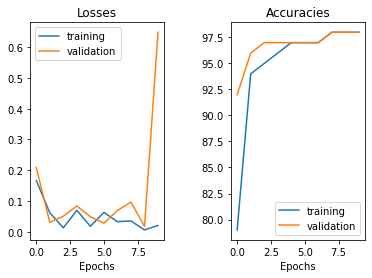

In [4]:
# Train Model

## Setting seeds for model repeatability and setting hyper-parameter
torch.manual_seed(0)  
n_epochs = 10
n_total_steps = len(train_loader)

## Empty lists to store statistics
train_losses = []
val_losses = []
train_correct = []
val_correct = []
trn_acc_list = []
val_acc_list = []

## Setting variable values to 0. These are used later to calculate the change in loss and accuracy.
trn_running_loss = 0.0
trn_running_correct = 0
val_running_loss = 0
val_running_correct = 0

## Train model on pre-determined no. of epochs
for i in range(n_epochs):
    trn_corr = 0
    val_corr = 0
    
    ### Run the training batches
    model_ft.train()
    for b, (X_train, y_train) in enumerate(barbar.Bar(train_loader)):
     
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        #### Apply the model
        y_pred = model_ft(X_train)
        loss = criterion(y_pred, y_train)

        #### Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        #### Update parameters
        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
           
        
    # writing data to tensorboard    
    trn_running_loss += loss.item()
    trn_running_correct += (predicted == y_train).sum().item()
            
    if (b+1) %1 == 0:
        writer.add_scalar('Training Loss', trn_running_loss/2, i*n_total_steps+b)
        writer.add_scalar('Training Acc', trn_running_correct/100, i*n_total_steps+b)
        
            
    ### Update lists with training statistics
    train_losses.append(loss)
    train_correct.append(trn_corr)
    train_acc = trn_corr*100/(len(train_data))
    trn_acc_list.append(train_acc)  


    ### Run the validation batches
    model_ft.eval()
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(val_loader):
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            #### Apply the model
            y_val_pred = model_ft(X_val)

            #### Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            val_corr += (predicted == y_val).sum()
                

    ### Update lists with validation statistics
    v_loss = criterion(y_val_pred, y_val)
    val_losses.append(v_loss)
    val_correct.append(val_corr)
    val_acc = val_corr*100/(len(val_data))
    val_acc_list.append(val_acc)
        
    # writing data to tensorboard   
    val_running_loss += v_loss.item()
    val_running_correct += (predicted == y_val).sum().item()
            
    if (b+1) % 100 == 0:
        writer.add_scalar('Validation Loss', val_running_loss/100, i*n_total_steps+b)
        writer.add_scalar('Validation Acc', val_running_correct/100, i*n_total_steps+b)


    ### Print statistics
    print(f'Epoch: {i+1}    Train Loss: {loss:.4f}    Train Correct: {trn_corr}    Train Acc: {train_acc}%    Val Loss: {v_loss:.4f}    Val Correct: {val_corr}    Val Acc: {val_acc}%')
    print()
print()
print()

# Plot training and validation statistics
print("Training and Validation Plots: ")
# Plot losses and accuracies at the end of each epoch
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.plot(train_losses, label='training')
ax1.plot(val_losses, label='validation')
ax1.set_xlabel('Epochs')
ax1.set_title('Losses')
ax1.legend()
ax2.plot(trn_acc_list, label='training')
ax2.plot(val_acc_list, label='validation')
ax2.set_xlabel('Epochs')
ax2.set_title('Accuracies')
ax2.legend()
plt.show()

## **Evaluate Network**
Now, as the network is trained, we can evaluate it.

624/624: [>...............................] - ETA 0.0s

Test Correct: 543/624    Test Accuracy: 87%


              precision    recall  f1-score   support

      NORMAL       1.00      0.65      0.79       234
   PNEUMONIA       0.83      1.00      0.91       390

    accuracy                           0.87       624
   macro avg       0.91      0.83      0.85       624
weighted avg       0.89      0.87      0.86       624





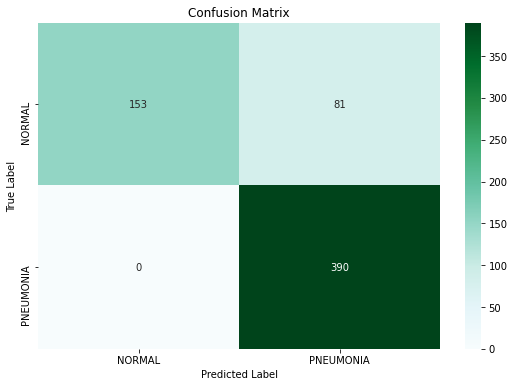

In [5]:
# Evaluate Network

## Run evaluation
## for evaluation, we'll pass whole test data in a single batch, since we are not doing backpropagation.
torch.manual_seed(0)
model_ft.eval()
test_data = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'Test'), transform=transform)
test_loader_complete = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)
with torch.no_grad():
    correct = 0
    for c, (X_test, y_test) in enumerate(barbar.Bar(test_loader_complete)):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model_ft(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()


## Extracting statistics        
y_test = y_test.view(-1).cpu()
predicted = predicted.view(-1).cpu()


## Printing statistics
Test_total = len(test_data)
Test_acc = correct*100/(len(test_data)) 
print()
print(f'Test Correct: {correct}/{Test_total}    Test Accuracy: {Test_acc:}%')
print()
print()

## Plotting statistics
### Classification report
print(classification_report(y_pred=predicted, y_true=y_test, target_names=test_data.classes))
print()
print()

### Heatmap of confusion matrix
arr = confusion_matrix(y_test, predicted)
df_cm = pandas.DataFrame(arr, test_data.classes, test_data.classes)
plt.figure(figsize = (9,6))
seaborn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title('Confusion Matrix')
plt.show()

The plot above indicates that our network is able to detect all causes of Pneumonia with 100% recall. We still have some false positive predictions of Pneumonia. This indicates that network can be further optimized to improve recall for class-Normal.<br>
F1-score for class - Pnemonia is 91% at 95% C.I. value.

AUC for class-Pneumonia is:  0.8269230769230769


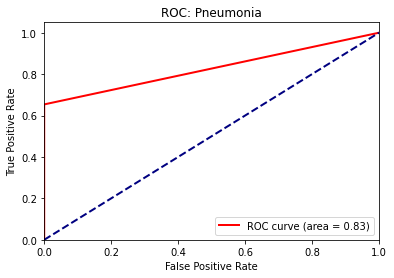

In [6]:
# Roc curves
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy
## coverting tensors to numpy arrays
y_test1 = y_test.numpy()
y_score1 = predicted.numpy()
lb = LabelBinarizer()
y_test = lb.fit_transform(y_test1)
y_test = numpy.hstack((y_test, 1 - y_test)) 
y_score = lb.fit_transform(y_score1)
y_score = numpy.hstack((y_score, 1 - y_score))


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  

# roc values for each class
print('AUC for class-Pneumonia is: ', roc_auc[1])
# Roc for Pneumonia
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Pneumonia')
plt.legend(loc="lower right")
plt.show()

The auc value for Pneumonia cases is around 0.83.

## **Model Interpretability**

Once, we are ready to accept the network, it's useful to review model interpretability. This helps us in understanding why our model has classify an object to a particular class.<br>
In this exercise, we'll use Captum's integrated gradient algorithm.

In [7]:
# Model Interpretability using Captum
## finding the class category
## Run evaluation
torch.manual_seed(0)
model_ft.eval()
model = model_ft.to(device)
test_data = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'predict'), transform=transform)
test_loader_complete = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=False)
with torch.no_grad():
    correct = 0
    for c, (X_test, y_test) in enumerate(barbar.Bar(test_loader_complete)):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]


## Extracting statistics        
y_test = y_test.view(-1).cpu()
predicted = predicted.view(-1).cpu()
correct += (predicted == y_test).sum()


## Printing statistics
Test_total = len(test_data)
Test_acc = correct*100/(len(test_data)) 
print()
print(f'Test Correct: {correct}/{Test_total}    Test Accuracy: {Test_acc:}%      Predicted:{predicted.item()}.')

1/1: [>...............................] - ETA 0.0s

Test Correct: 1/1    Test Accuracy: 100%      Predicted:1.


It appears that our model has predicted the class correctly. Let's apply integrated gradient algorithm to our model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


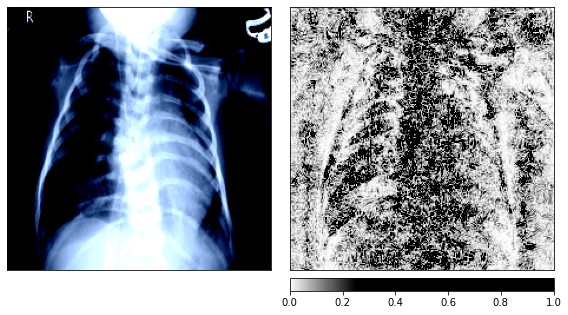

In [8]:
# Integrated gradient algorithm to check model interpretability

## input variables
input = X_test
pred_label_idx = predicted

## importing logrithm and applying
integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(X_test, target=predicted, n_steps=200)

transformed_img, _ = next(iter(test_data))
default_cmap = LinearSegmentedColormap.from_list('custom blue',  [(0, '#ffffff'), (0.25, '#000000'),(1, '#000000')], N=256)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(numpy.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      numpy.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Above image provides graphical representation of the areas (features), shown as densely populated black dot, that attributes to model's prediction. 